In [1]:
!pip install quantecon

In [2]:
import matplotlib.pyplot as plt
import quantecon as qe
import numpy as np
import networkx as nx
from matplotlib import cm
import matplotlib as mpl
from itertools import cycle

In [3]:
nodes = ['DG', 'DC', 'NG', 'NC', 'AG', 'AC']
P = [[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
     [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
     [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
     [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
     [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
     [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]]

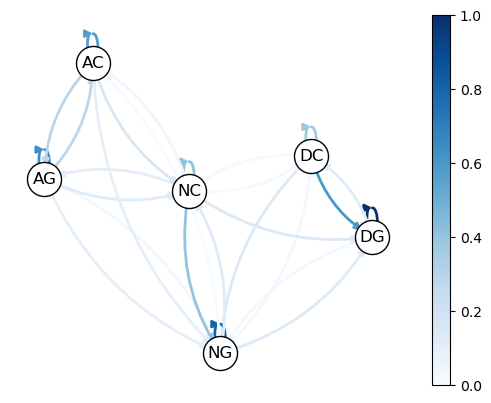

In [4]:
G = nx.MultiDiGraph()
edge_ls = []
label_dict = {}

for start_idx, node_start in enumerate(nodes):
    for end_idx, node_end in enumerate(nodes):
        value = P[start_idx][end_idx]
        if value != 0:
            G.add_edge(node_start,node_end, weight=value, len=100)

pos = nx.spring_layout(G, seed=10)
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, node_size=600, edgecolors='black', node_color='white')
nx.draw_networkx_labels(G, pos)

arc_rad = 0.2
curved_edges = [edge for edge in G.edges()]
edges = nx.draw_networkx_edges(G, pos, ax=ax, connectionstyle=f'arc3, rad = {arc_rad}', edge_cmap=cm.Blues, width=2,
    edge_color=[G[nodes[0]][nodes[1]][0]['weight'] for nodes in G.edges])

pc = mpl.collections.PatchCollection(edges, cmap=cm.Blues)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

In [5]:
ψ_0 = (0.3, 0.7)           # probabilities over {0, 1}
cdf = np.cumsum(ψ_0)       # convert into cumulative distribution
qe.random.draw(cdf, 5)   # generate 5 independent draws from ψ

array([1, 1, 1, 1, 1])

In [6]:
def mc_sample_path(P, ψ_0=None, ts_length=1_000):

    # set up
    P = np.asarray(P)
    X = np.empty(ts_length, dtype=int)

    # Convert each row of P into a cdf
    P_dist = np.cumsum(P, axis=1)  # Convert rows into cdfs

    # draw initial state, defaulting to 0
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0))
    else:
        X_0 = 0

    # simulate
    X[0] = X_0
    for t in range(ts_length - 1):
        X[t+1] = qe.random.draw(P_dist[X[t], :])

    return X

In [7]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

In [8]:
mc_sample_path(P, ψ_0=[1.0, 0.0], ts_length=10)

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
X = mc_sample_path(P, ψ_0=[0.1, 0.9], ts_length=1_000_000)
np.mean(X == 0)

0.249313

In [10]:
mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

0.249962

In [11]:
%time mc_sample_path(P, ts_length=1_000_000) # Our homemade code version

CPU times: user 1.05 s, sys: 4 ms, total: 1.06 s
Wall time: 1.06 s


array([0, 1, 1, ..., 0, 0, 0])

In [12]:
%time mc.simulate(ts_length=1_000_000) # qe code version

CPU times: user 13.2 ms, sys: 48 µs, total: 13.3 ms
Wall time: 12.8 ms


array([1, 1, 1, ..., 1, 1, 1])

In [13]:
mc = qe.MarkovChain(P, state_values=('unemployed', 'employed'))
mc.simulate(ts_length=4, init='employed')

array(['employed', 'unemployed', 'employed', 'employed'], dtype='<U10')

In [14]:
mc.simulate(ts_length=4, init='unemployed')

array(['unemployed', 'unemployed', 'employed', 'employed'], dtype='<U10')

In [15]:
mc.simulate(ts_length=4)  # Start at randomly chosen initial state

array(['employed', 'unemployed', 'unemployed', 'employed'], dtype='<U10')

In [16]:
mc.simulate_indices(ts_length=4)

array([0, 0, 1, 1])

In [17]:
P = np.array([[0.4, 0.6],
              [0.2, 0.8]])
ψ = (0.25, 0.75)
ψ @ P

array([0.25, 0.75])

In [18]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P)
mc.stationary_distributions  # Show all stationary distributions

array([[0.25, 0.75]])

In [19]:
P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])
P @ P

array([[0.947046, 0.050721, 0.002233],
       [0.253605, 0.648605, 0.09779 ],
       [0.07366 , 0.64516 , 0.28118 ]])

In [20]:
def iterate_ψ(ψ_0, P, ts_length):
    n = len(P)
    ψ_t = np.empty((ts_length, n))
    ψ = ψ_0
    for t in range(ts_length):
        ψ_t[t] = ψ
        ψ = ψ @ P
    return np.array(ψ_t)

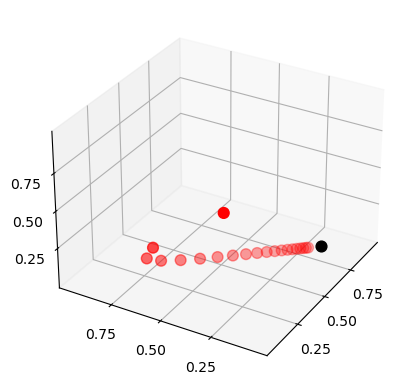

In [21]:
ψ_0 = (0.0, 0.2, 0.8)        # Initial condition

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
       xticks=(0.25, 0.5, 0.75),
       yticks=(0.25, 0.5, 0.75),
       zticks=(0.25, 0.5, 0.75))

ψ_t = iterate_ψ(ψ_0, P, 20)

ax.scatter(ψ_t[:,0], ψ_t[:,1], ψ_t[:,2], c='r', s=60)
ax.view_init(30, 210)

mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=60)

plt.show()

In [22]:
def generate_initial_values(num_distributions):
    n = len(P)
    ψ_0s = np.empty((num_distributions, n))

    for i in range(num_distributions):
        draws = np.random.randint(1, 10_000_000, size=n)

        # Scale them so that they add up into 1
        ψ_0s[i,:] = np.array(draws/sum(draws))

    return ψ_0s

In [23]:
def plot_distribution(P, ts_length, num_distributions):

    # Get parameters of transition matrix
    n = len(P)
    mc = qe.MarkovChain(P)
    ψ_star = mc.stationary_distributions[0]

    ## Draw the plot
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=[11, 5])
    plt.subplots_adjust(wspace=0.35)

    ψ_0s = generate_initial_values(num_distributions)

    # Get the path for each starting value
    for ψ_0 in ψ_0s:
        ψ_t = iterate_ψ(ψ_0, P, ts_length)

        # Obtain and plot distributions at each state
        for i in range(n):
            axes[i].plot(range(0, ts_length), ψ_t[:,i], alpha=0.3)

    # Add labels
    for i in range(n):
        axes[i].axhline(ψ_star[i], linestyle='dashed', lw=2, color = 'black',
                        label = fr'$\psi^*({i})$')
        axes[i].set_xlabel('t')
        axes[i].set_ylabel(fr'$\psi_t({i})$')
        axes[i].legend()

    plt.show()

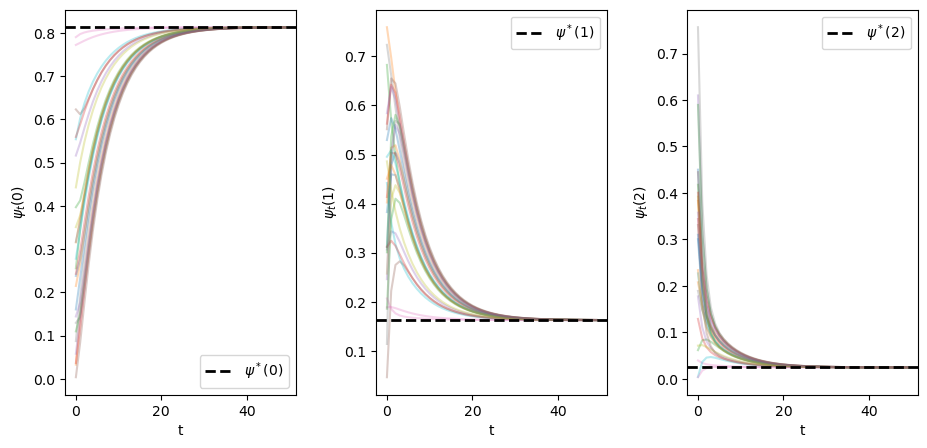

In [24]:
# Define the number of iterations
# and initial distributions
ts_length = 50
num_distributions = 25

P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])

plot_distribution(P, ts_length, num_distributions)

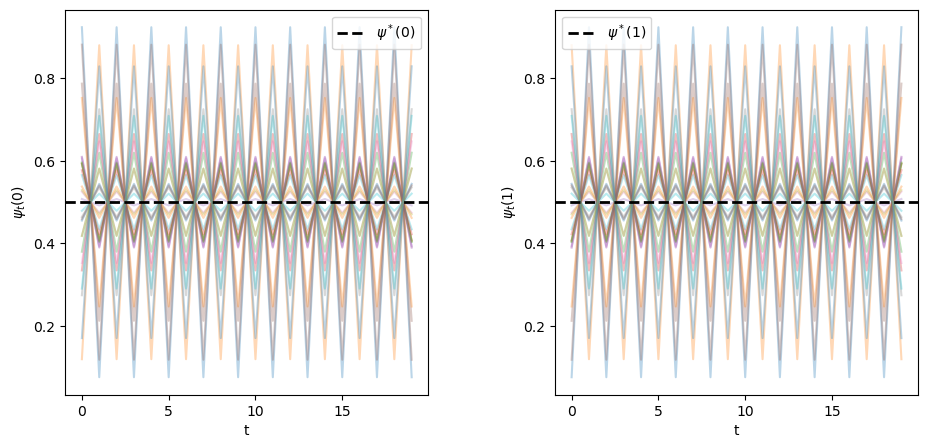

In [25]:
P = np.array([[0, 1],
              [1, 0]])

ts_length = 20
num_distributions = 30

plot_distribution(P, ts_length, num_distributions)

In [26]:
P = np.array([[0.68, 0.12, 0.20],
              [0.50, 0.24, 0.26],
              [0.36, 0.18, 0.46]])
P_power = np.linalg.matrix_power(P, 20)
P_power

array([[0.56145769, 0.15565164, 0.28289067],
       [0.56145769, 0.15565164, 0.28289067],
       [0.56145769, 0.15565164, 0.28289067]])

In [27]:
ψ_star_p = P_power[0]
ψ_star_p

array([0.56145769, 0.15565164, 0.28289067])

In [28]:
mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ψ_star

array([0.56145769, 0.15565164, 0.28289067])

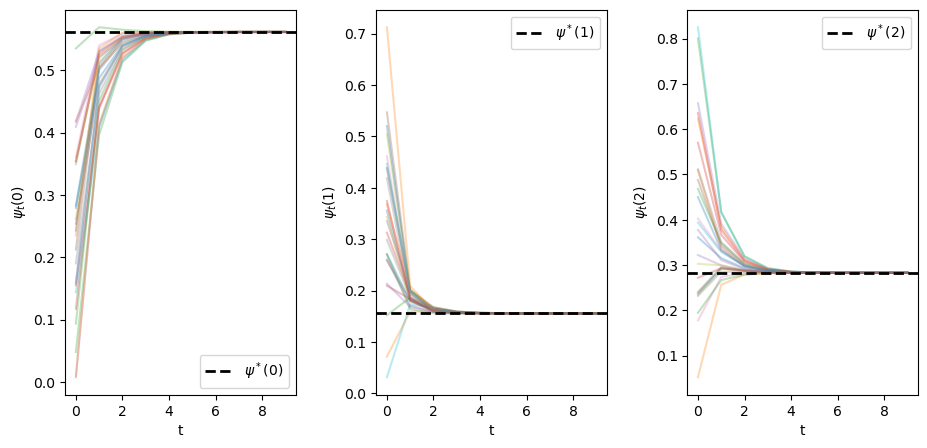

In [29]:
ts_length = 10
num_distributions = 25
plot_distribution(P, ts_length, num_distributions)

In [30]:
P_eigenvals = np.linalg.eigvals(P)
P_eigenvals

array([1.        , 0.28219544, 0.09780456])

In [31]:
P_hamilton = np.array([[0.971, 0.029, 0.000],
                       [0.145, 0.778, 0.077],
                       [0.000, 0.508, 0.492]])

hamilton_eigenvals = np.linalg.eigvals(P_hamilton)
hamilton_eigenvals

array([1.        , 0.85157412, 0.38942588])

In [32]:
sp_gap_P = P_eigenvals[0] - np.diff(P_eigenvals)[0]
sp_gap_hamilton = hamilton_eigenvals[0] - np.diff(hamilton_eigenvals)[0]

sp_gap_P > sp_gap_hamilton

True

In [33]:
P = np.array([[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
              [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
              [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
              [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
              [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
              [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]])

np.linalg.matrix_power(P,3)

array([[0.764927, 0.133481, 0.085949, 0.011481, 0.002956, 0.001206],
       [0.658861, 0.131559, 0.161367, 0.031703, 0.011296, 0.005214],
       [0.291394, 0.057788, 0.439702, 0.113408, 0.062707, 0.035001],
       [0.272459, 0.051361, 0.365075, 0.132207, 0.108152, 0.070746],
       [0.064129, 0.012533, 0.232875, 0.154385, 0.299243, 0.236835],
       [0.072865, 0.014081, 0.244139, 0.160905, 0.265846, 0.242164]])

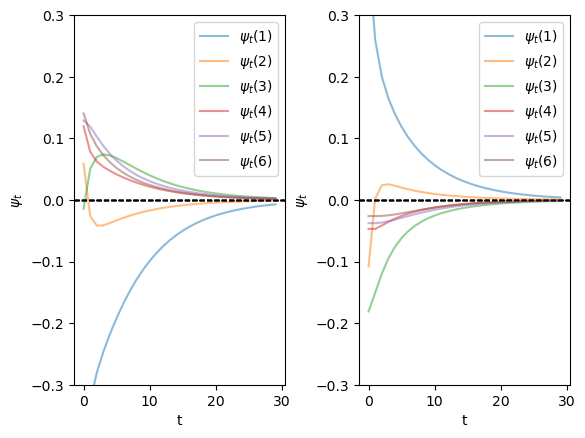

In [34]:
ts_length = 30
num_distributions = 20
nodes = ['DG', 'DC', 'NG', 'NC', 'AG', 'AC']

# Get parameters of transition matrix
n = len(P)
mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ψ_0 = np.array([[1/6 for i in range(6)],
                [0 if i != 0 else 1 for i in range(6)]])
## Draw the plot
fig, axes = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0.35)
for idx in range(2):
    ψ_t = iterate_ψ(ψ_0[idx], P, ts_length)
    for i in range(n):
        axes[idx].plot(ψ_t[:, i] - ψ_star[i], alpha=0.5, label=fr'$\psi_t({i+1})$')
        axes[idx].set_ylim([-0.3, 0.3])
        axes[idx].set_xlabel('t')
        axes[idx].set_ylabel(fr'$\psi_t$')
        axes[idx].legend()
        axes[idx].axhline(0, linestyle='dashed', lw=1, color = 'black')

plt.show()